<a href="https://colab.research.google.com/github/igt14/Factors-Determining-COVID-19-Vaccine-Acceptance/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading our dataset

In [ ]:
# Installing the libraries we will need
!pip install researchpy
!pip install factor_analyzer==0.2.3

In [ ]:
# Importing the libraries we will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
import scipy.stats as stats

In [ ]:
# Dataset url = https://docs.google.com/spreadsheets/d/1G2d2IBrGsrIZI1dBunv1H5iUbVmz6p2g/edit?usp=sharing&ouid=106805906085365476424&rtpof=true&sd=true
covid = pd.read_excel('/content/COVID_vaccine_data.xlsx', sheet_name='COVID_vaccine', na_values=' ')

# 2. Previewing our dataset

In [ ]:
# Checking number of records
covid.shape

(2978, 95)

In [ ]:
# Checking the information on our dataset
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2978 entries, 0 to 2977
Data columns (total 95 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   healthcare_worker                          2966 non-null   float64       
 1   family_member_covid                        2706 non-null   float64       
 2   family_member_covid_test                   772 non-null    float64       
 3   fam_mem_covid_dx                           930 non-null    float64       
 4   fm_mem_covid_hospitalized                  361 non-null    float64       
 5   covid_follow                               2952 non-null   float64       
 6   covid_information_source___1               2978 non-null   int64         
 7   covid_information_source___2               2978 non-null   int64         
 8   covid_information_source___3               2978 non-null   int64         
 9   covid_information_s

In [ ]:
# Previewing the top of our dataset
covid.head()

,healthcare_worker,family_member_covid,family_member_covid_test,fam_mem_covid_dx,fm_mem_covid_hospitalized,covid_follow,covid_information_source___1,covid_information_source___2,covid_information_source___3,covid_information_source___4,covid_information_source___5,covid_information_source___6,covid_information_source___7,covid_information_source___8,covid_information_source___9,covid_information_source___10,confine,job,infection,food,death,hospital_access,covid_state,sd,ld,hw,fm,er,reopening,second_wave,number,state,belief,age,child,smoke,dm,immune,pregnant,hosp_rate,...,covid_symptoms___4,covid_symptoms___5,vaccine_pcv_flu,mask_gloves___1,mask_gloves___2,social_distance_feet,isolation,corona_live,spread___1,spread___2,spread___3,spread___4,chloroquin,drug_trial,vaccine_trial,hospital,vent,administration,new_vaccine,new_medication,covid_vaccine,covid_vaccine_cause___1,covid_vaccine_cause___2,covid_vaccine_cause___3,covid_vaccine_cause___4,covid_vaccine_cause___5,flu_shot_y_n,confidence_level,Gender_string,your_age,your_education,your_race,financial_status,US_State,Census_region,Region,Vaccine_Launch (PRE_POST),summary_explanation_of_research_timestamp,Knowledge_normalized,Perceived_threat_normalized
0,1.0,0.0,NaN,NaN,NaN,5.0,1,0,0,1,NaN,0,1,1,0,1,3.0,3.0,3.0,3.0,4.0,2.0,3.0,5.0,5.0,5.0,5.0,4.0,4.0,1.0,1.0,4.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1,1,1.0,1,1,1.0,1.0,0.0,1,1,1,1,1.0,3.0,2.0,5.0,5.0,5.0,3.0,4.0,1,NaN,NaN,NaN,NaN,NaN,1.0,9.0,Female,4.0,5.0,White,3.0,Florida,South Atlantic,South,No,2020-05-30 17:00:00,7.496125,4.871027
1,0.0,0.0,NaN,NaN,NaN,5.0,1,0,0,1,0.0,0,0,0,0,0,3.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,2.0,3.0,4.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,...,1,1,1.0,1,0,1.0,1.0,1.0,1,1,1,1,1.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0,1,NaN,NaN,NaN,NaN,NaN,1.0,8.0,Male,2.0,5.0,Asian,3.0,New York,Mid-Atlantic,Northeast,No,2020-05-31 07:16:00,NaN,3.947653
2,1.0,1.0,0.0,NaN,NaN,3.0,1,0,1,1,0.0,0,0,1,1,0,5.0,1.0,4.0,1.0,4.0,1.0,4.0,5.0,4.0,5.0,4.0,4.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,NaN,1.0,1.0,0.0,1.0,...,1,1,1.0,1,1,1.0,1.0,1.0,1,1,1,0,0.5,2.0,2.0,5.0,5.0,1.0,3.0,4.0,1,NaN,NaN,NaN,NaN,NaN,1.0,10.0,Female,3.0,4.0,White,3.0,Pennsylvania,Mid-Atlantic,Northeast,No,2020-06-01 08:07:00,NaN,5.812587
3,1.0,0.0,NaN,NaN,NaN,6.0,0,1,0,1,1.0,0,1,1,0,0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,4.0,1.0,5.0,1.0,4.0,1.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,1.0,0,1,1.0,1.0,1.0,1,1,1,1,0.0,5.0,5.0,5.0,5.0,4.0,3.0,1.0,0,NaN,NaN,NaN,NaN,NaN,1.0,8.0,Female,2.0,2.0,White,2.0,Pennsylvania,Mid-Atlantic,Northeast,No,2020-06-01 08:44:00,6.246485,NaN
4,1.0,1.0,1.0,0.0,NaN,6.0,1,0,0,0,1.0,0,0,0,0,0,2.0,2.0,3.0,2.0,4.0,2.0,3.0,5.0,5.0,5.0,3.0,3.0,2.0,4.0,2.0,5.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1.0,1,1,1.0,1.0,0.0,1,1,1,1,0.0,2.0,2.0,5.0,5.0,5.0,2.0,2.0,0,NaN,NaN,NaN,NaN,NaN,1.0,9.0,Female,2.0,1.0,White,2.0,Pennsylvania,Mid-Atlantic,Northeast,No,2020-06-01 08:57:00,6.228922,5.329589


In [ ]:
# Previewing the bottom of our dataset
covid.tail()

,healthcare_worker,family_member_covid,family_member_covid_test,fam_mem_covid_dx,fm_mem_covid_hospitalized,covid_follow,covid_information_source___1,covid_information_source___2,covid_information_source___3,covid_information_source___4,covid_information_source___5,covid_information_source___6,covid_information_source___7,covid_information_source___8,covid_information_source___9,covid_information_source___10,confine,job,infection,food,death,hospital_access,covid_state,sd,ld,hw,fm,er,reopening,second_wave,number,state,belief,age,child,smoke,dm,immune,pregnant,hosp_rate,...,covid_symptoms___4,covid_symptoms___5,vaccine_pcv_flu,mask_gloves___1,mask_gloves___2,social_distance_feet,isolation,corona_live,spread___1,spread___2,spread___3,spread___4,chloroquin,drug_trial,vaccine_trial,hospital,vent,administration,new_vaccine,new_medication,covid_vaccine,covid_vaccine_cause___1,covid_vaccine_cause___2,covid_vaccine_cause___3,covid_vaccine_cause___4,covid_vaccine_cause___5,flu_shot_y_n,confidence_level,Gender_string,your_age,your_education,your_race,financial_status,US_State,Census_region,Region,Vaccine_Launch (PRE_POST),summary_explanation_of_research_timestamp,Knowledge_normalized,Perceived_threat_normalized
2973,0.0,NaN,NaN,0.0,NaN,4.0,0,1,0,0,0.0,0,0,1,0,0,1.0,5.0,4.0,2.0,5.0,1.0,4.0,5.0,4.0,5.0,5.0,3.0,4.0,1.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,0,1.0,1,1,1.0,1.0,0.0,0,1,0,0,1.0,4.0,5.0,5.0,2.0,1.0,2.0,3.0,1,0.0,0.0,0.0,0.0,1.0,1.0,6.0,Male,2.0,2.0,White,2.0,North Carolina,South Atlantic,NaN,Yes,2021-01-06 14:40:00,8.534186,6.069682
2974,0.0,0.0,NaN,0.0,NaN,6.0,0,1,0,1,0.0,0,1,0,0,0,5.0,4.0,3.0,2.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,3.0,3.0,1.0,5.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1.0,1,1,1.0,1.0,0.0,0,1,1,1,0.5,1.0,1.0,5.0,3.0,3.0,NaN,NaN,1,1.0,0.0,0.0,0.0,0.0,1.0,8.0,Female,3.0,2.0,White,2.0,Tennessee,East South Central,NaN,Yes,2021-01-06 16:48:00,8.391780,6.312461
2975,0.0,NaN,NaN,0.0,NaN,3.0,1,1,1,1,0.0,0,0,0,1,0,2.0,1.0,3.0,1.0,1.0,1.0,3.0,5.0,3.0,5.0,5.0,5.0,2.0,2.0,1.0,1.0,4.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,...,1,1,0.0,1,0,1.0,1.0,1.0,1,1,1,0,0.5,3.0,3.0,4.0,3.0,5.0,1.0,2.0,1,1.0,1.0,1.0,1.0,1.0,1.0,9.0,Male,4.0,2.0,Black,2.0,New York,Mid-Atlantic,NaN,Yes,2021-01-06 17:19:00,NaN,2.492443
2976,1.0,NaN,NaN,0.0,NaN,3.0,1,0,0,1,0.0,0,1,1,0,0,3.0,2.0,3.0,2.0,3.0,1.0,4.0,5.0,3.0,4.0,3.0,2.0,3.0,3.0,2.0,2.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1,1,1.0,1,1,1.0,0.0,1.0,0,1,1,1,1.0,5.0,5.0,5.0,5.0,4.0,1.0,3.0,1,0.0,0.0,0.0,0.0,1.0,1.0,9.0,Male,4.0,4.0,White,2.0,Utah,Mountain,NaN,Yes,2021-01-06 17:57:00,9.148600,4.053332
2977,0.0,1.0,1.0,1.0,0.0,6.0,1,0,0,0,0.0,0,0,0,0,0,2.0,1.0,2.0,1.0,1.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,2.0,4.0,3.0,1.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,...,1,1,0.0,1,1,1.0,1.0,1.0,1,1,1,1,1.0,2.0,3.0,5.0,3.0,5.0,1.0,4.0,1,1.0,0.0,0.0,0.0,0.0,1.0,9.0,Female,5.0,NaN,NaN,2.0,NaN,NaN,NaN,Yes,2021-01-06 18:07:00,NaN,2.862377


# 3. Cleaning our dataset

## 3.1 Dropping uneccessary columns

In [ ]:
# Specifying the irrelevant columns
irrelevant = ['Perceived_threat_normalized', 'Knowledge_normalized', 'summary_explanation_of_research_timestamp', 'Region', 'US_State', 'confidence_level',
              'Vaccine_Launch (PRE_POST)','age', 'child', 'smoke', 'dm', 'immune', 'pregnant', 'hosp_rate', 'death_rate', 'incubation', 'corona', 'animal',
              'screening', 'hand_wash', 'climate', 'sunlight', 'nasal_spray', 'hot_beverages', 'hand_sanitize', 'baby_wipes', 'spread___1', 'spread___2', 
              'spread___3', 'spread___4', 'flu_shot_y_n', 'covid_symptoms___1', 'covid_symptoms___2', 'covid_symptoms___3', 'covid_symptoms___4', 
              'covid_symptoms___5', 'vaccine_pcv_flu', 'mask_gloves___1', 'mask_gloves___2', 'spread___1', 'spread___2', 'spread___3', 'spread___4']
covid.drop(columns=irrelevant, inplace=True)

## 3.2 Missing data

In [ ]:
def missing(df):
  # Creating a dataframe showing percentage of missing values
  percentage = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_frame()

  # Renaming the column
  percentage.columns = ['Percentage Missing']

  # Returning a dataframe with the columns that have more than 10% missing values
  return percentage[percentage['Percentage Missing'] > 10]

In [ ]:
# Checking for missing values
missing(covid)

,Percentage Missing
fm_mem_covid_hospitalized,87.877770
family_member_covid_test,74.076561
fam_mem_covid_dx,68.770987
covid_vaccine_cause___5,55.406313
covid_vaccine_cause___4,55.406313
covid_vaccine_cause___3,55.406313
covid_vaccine_cause___2,55.406313
covid_vaccine_cause___1,55.406313


The above columns have a lot of missing values and we will keep this in mind if we do any analysis using them

## 3.3 Duplicates


In [ ]:
# Checking for duplicates
covid.duplicated().any()

False

## 3.4 Anomalies/Outliers

In [ ]:
# Creating a list of columns that we will look at closely
interest = ['covid_vaccine', 'Gender_string', 'your_age', 'your_education', 'your_race', 'financial_status', 'Census_region', 'healthcare_worker']

# Checking that they don't have anomalies
for i in interest:
  print(i, covid[i].unique())

covid_vaccine [1 0]
Gender_string ['Female' 'Male' nan]
your_age [ 4.  2.  3.  5.  1. nan]
your_education [ 5.  4.  2.  1.  3. nan]
your_race ['White' 'Asian' nan 'Black' 'Hispanic' 'Other']
financial_status [ 3.  2.  4.  1. nan]
Census_region ['South Atlantic' 'Mid-Atlantic' 'East North Central' 'East South Central'
 'Pacific' nan 'West North Central' 'West South Central' 'New England'
 'Mountain']
healthcare_worker [ 1.  0. nan]


There are no unexpected values

# 4. Exploratory Data Analysis 

In [ ]:
# Creating a copy of the dataset for exploratory data analysis
covid_eda = covid.copy()
covid_eda.head()

,healthcare_worker,family_member_covid,family_member_covid_test,fam_mem_covid_dx,fm_mem_covid_hospitalized,covid_follow,covid_information_source___1,covid_information_source___2,covid_information_source___3,covid_information_source___4,covid_information_source___5,covid_information_source___6,covid_information_source___7,covid_information_source___8,covid_information_source___9,covid_information_source___10,confine,job,infection,food,death,hospital_access,covid_state,sd,ld,hw,fm,er,reopening,second_wave,number,state,belief,social_distance_feet,isolation,corona_live,chloroquin,drug_trial,vaccine_trial,hospital,vent,administration,new_vaccine,new_medication,covid_vaccine,covid_vaccine_cause___1,covid_vaccine_cause___2,covid_vaccine_cause___3,covid_vaccine_cause___4,covid_vaccine_cause___5,Gender_string,your_age,your_education,your_race,financial_status,Census_region
0,1.0,0.0,NaN,NaN,NaN,5.0,1,0,0,1,NaN,0,1,1,0,1,3.0,3.0,3.0,3.0,4.0,2.0,3.0,5.0,5.0,5.0,5.0,4.0,4.0,1.0,1.0,4.0,5.0,1.0,1.0,0.0,1.0,3.0,2.0,5.0,5.0,5.0,3.0,4.0,1,NaN,NaN,NaN,NaN,NaN,Female,4.0,5.0,White,3.0,South Atlantic
1,0.0,0.0,NaN,NaN,NaN,5.0,1,0,0,1,0.0,0,0,0,0,0,3.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,2.0,3.0,4.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0,1,NaN,NaN,NaN,NaN,NaN,Male,2.0,5.0,Asian,3.0,Mid-Atlantic
2,1.0,1.0,0.0,NaN,NaN,3.0,1,0,1,1,0.0,0,0,1,1,0,5.0,1.0,4.0,1.0,4.0,1.0,4.0,5.0,4.0,5.0,4.0,4.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,0.5,2.0,2.0,5.0,5.0,1.0,3.0,4.0,1,NaN,NaN,NaN,NaN,NaN,Female,3.0,4.0,White,3.0,Mid-Atlantic
3,1.0,0.0,NaN,NaN,NaN,6.0,0,1,0,1,1.0,0,1,1,0,0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,4.0,1.0,5.0,1.0,4.0,1.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,0.0,5.0,5.0,5.0,5.0,4.0,3.0,1.0,0,NaN,NaN,NaN,NaN,NaN,Female,2.0,2.0,White,2.0,Mid-Atlantic
4,1.0,1.0,1.0,0.0,NaN,6.0,1,0,0,0,1.0,0,0,0,0,0,2.0,2.0,3.0,2.0,4.0,2.0,3.0,5.0,5.0,5.0,3.0,3.0,2.0,4.0,2.0,5.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,5.0,5.0,5.0,2.0,2.0,0,NaN,NaN,NaN,NaN,NaN,Female,2.0,1.0,White,2.0,Mid-Atlantic


In [ ]:
# Creating a user defined function to change values from numerical to categorical for better visualizations
def categorize(df, column, replace, replace_with):
  df[column].replace(to_replace=replace, value=replace_with, inplace=True)

## 4.1 Univariate Analysis

In [ ]:
# Creating a user defined function for univariate visuals 
def uni_visuals(column, kind, title, xlabel, ylabel):
  sns.set(font_scale=1.2)
  plt.figure(figsize=(7,6))
  if kind == 'pie':
    plt.pie(x=covid_eda[column].value_counts(), autopct='%1.1f%%', pctdistance=1.2)
    plt.legend(covid_eda[column].value_counts().index, bbox_to_anchor=(1.05, 1.0), loc='upper left')
  elif kind == 'bar':
    plt.bar(x=covid_eda[column].value_counts().index, height=covid_eda[column].value_counts())
    plt.xticks(rotation='vertical')
  plt.xlabel(xlabel, labelpad=14)
  plt.ylabel(ylabel, labelpad=14)
  plt.title(title, y=1.02)
  return plt.show()

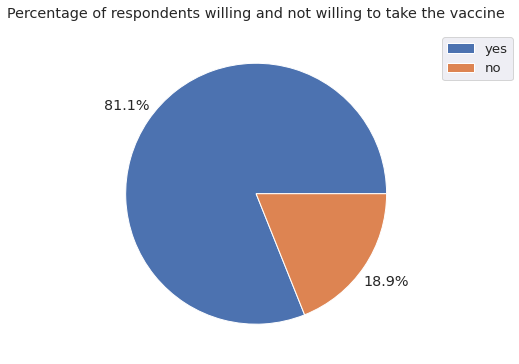

In [ ]:
# Changing values from numerical to categorical
categorize(covid_eda, 'covid_vaccine', [0,1], ['no', 'yes'])
# Pie chart showing the percentage of respondents willing and not willing to take the vaccine
uni_visuals('covid_vaccine', 'pie', 'Percentage of respondents willing and not willing to take the vaccine', '', '')

In [ ]:
# What are the biggest concerns on taking the COVID-19 vaccine?
# To do this we first create a dataframe with the information we need
concern = covid_eda[['covid_vaccine_cause___1', 'covid_vaccine_cause___2', 'covid_vaccine_cause___3', 'covid_vaccine_cause___4','covid_vaccine_cause___5']]
#
# Changing the column names
concern.columns = ['Possible side effects', 'Doubts about the benefits', 'Cost of the vaccine', 'Not at risk for serious disease', 'No specific cause/concern']
#
# Previewing our dataset
concern.tail()

,Possible side effects,Doubts about the benefits,Cost of the vaccine,Not at risk for serious disease,No specific cause/concern
2973,0.0,0.0,0.0,0.0,1.0
2974,1.0,0.0,0.0,0.0,0.0
2975,1.0,1.0,1.0,1.0,1.0
2976,0.0,0.0,0.0,0.0,1.0
2977,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Changing the 0,1 to no,yes
for i in concern.columns:
  categorize(concern, i, [0,1], ['no', 'yes'])

# To see if it worked
concern.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Possible side effects,Doubts about the benefits,Cost of the vaccine,Not at risk for serious disease,No specific cause/concern
2973,no,no,no,no,yes
2974,yes,no,no,no,no
2975,yes,yes,yes,yes,yes
2976,no,no,no,no,yes
2977,yes,no,no,no,no


In [ ]:
# Find out how many said yes/no for each specific concern
# Creating an empty dataframe
concern_count = pd.DataFrame()

# Appending the value counts for each concern
for i in range(concern.shape[1]):
  concern_count = concern_count.append(concern.iloc[:,i].value_counts())

# Checking the value counts for each concern
concern_count

,no,yes
Possible side effects,583.0,745.0
Doubts about the benefits,1172.0,156.0
Cost of the vaccine,1220.0,108.0
Not at risk for serious disease,1265.0,63.0
No specific cause/concern,816.0,512.0


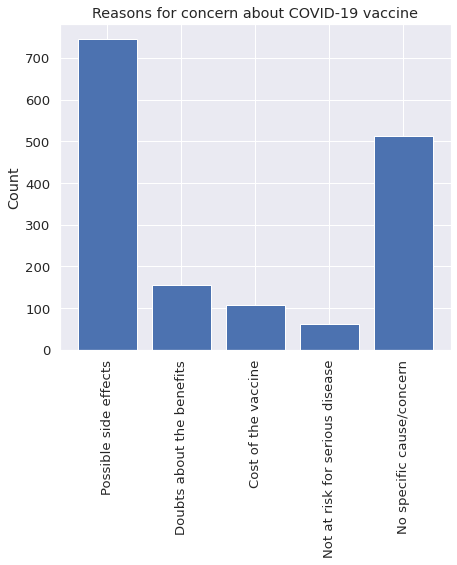

In [ ]:
# Bar char to visualize main concern
plt.figure(figsize=(7,6))
plt.bar(x=concern_count.index, height=concern_count['yes'])
plt.xticks(rotation='vertical')
plt.ylabel('Count')
plt.title('Reasons for concern about COVID-19 vaccine')
plt.show()

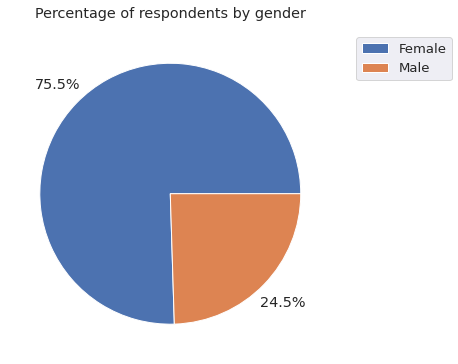

In [ ]:
# Pie chart showing the percentage of respondents by gender
uni_visuals('Gender_string', 'pie', 'Percentage of respondents by gender', '', '')

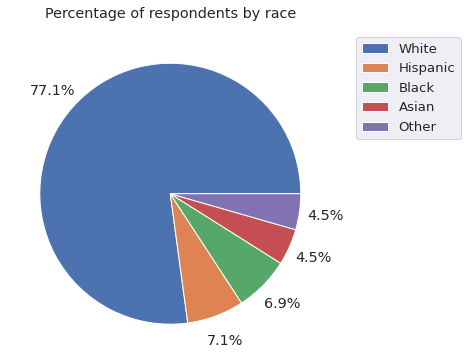

In [ ]:
# Pie chart showing the percentage of respondents by race
uni_visuals('your_race', 'pie', 'Percentage of respondents by race', '', '')

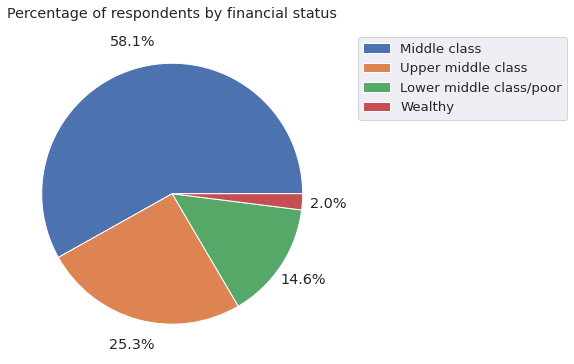

In [ ]:
# Changing values from numerical to categorical
categorize(covid_eda, 'financial_status', [1,2,3,4], ['Lower middle class/poor', 'Middle class', 'Upper middle class', 'Wealthy'])
# Pie chart showing the percentage of respondents by financial status
uni_visuals('financial_status', 'pie', 'Percentage of respondents by financial status', '', '')

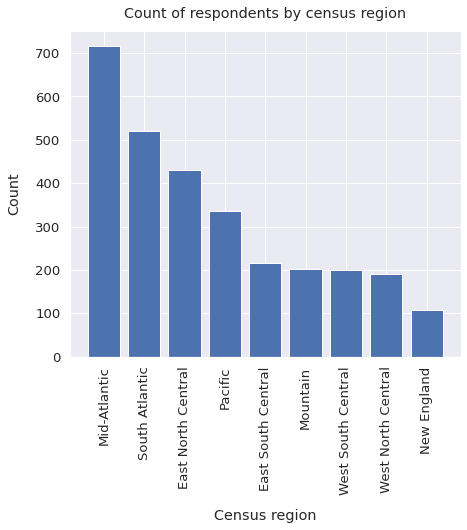

In [ ]:
# Bar chart showing count of respondents by census region
uni_visuals('Census_region', 'bar', 'Count of respondents by census region', 'Census region', 'Count')

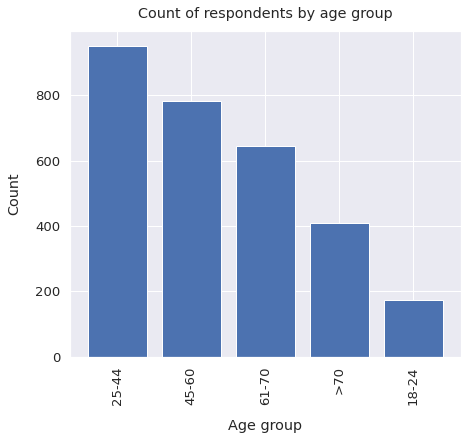

In [ ]:
# Changing values from numerical to categorical
categorize(covid_eda, 'your_age', [1,2,3,4,5,6], ['18-24', '25-44', '45-60', '61-70', '>70', 'prefer not to answer'])
# Bar chart showing count of respondents by age group
uni_visuals('your_age', 'bar', 'Count of respondents by age group', 'Age group', 'Count')

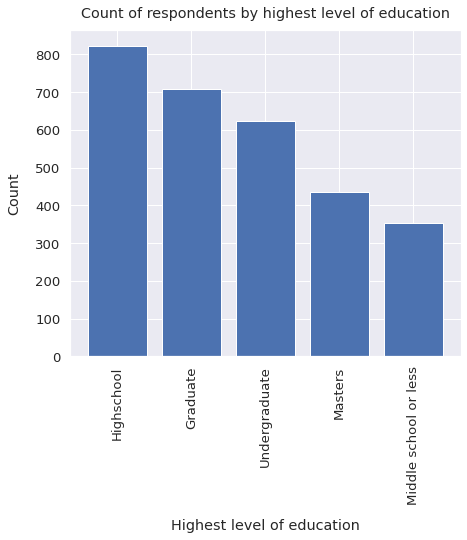

In [ ]:
# Changing values from numerical to categorical
categorize(covid_eda, 'your_education', [1,2,3,4,5,6,7,8,9], ['Middle school or less', 'Highschool', 'Undergraduate', 'Graduate', 'Masters', 'Doctorate', 'Professional degree', 'Other', 'Prefer not to say'])
# Bar chart showing count of respondents by highest level of education
uni_visuals('your_education', 'bar', 'Count of respondents by highest level of education', 'Highest level of education', 'Count')

In [ ]:
# Where are people getting their information on COVID?
# To do this we first create a dataframe with the information we need
info = covid_eda[['covid_information_source___1', 'covid_information_source___2', 'covid_information_source___3', 'covid_information_source___4',
          'covid_information_source___5', 'covid_information_source___6', 'covid_information_source___7', 'covid_information_source___8',
          'covid_information_source___9', 'covid_information_source___10']]

# Changing the column names
info.columns = ['Television news channel', 'Friends and family', 'WHO website', 'CDC website', 'Facebook', 'WhatsApp', 'City, state or other official website',
                'National health websites', 'Your doctor or local hospital', 'Scientific journal']

# Previewing the datasets
info.head()

,Television news channel,Friends and family,WHO website,CDC website,Facebook,WhatsApp,"City, state or other official website",National health websites,Your doctor or local hospital,Scientific journal
0,1,0,0,1,NaN,0,1,1,0,1
1,1,0,0,1,0.0,0,0,0,0,0
2,1,0,1,1,0.0,0,0,1,1,0
3,0,1,0,1,1.0,0,1,1,0,0
4,1,0,0,0,1.0,0,0,0,0,0


In [ ]:
# Changing the 0,1 to no,yes
for i in info.columns:
  categorize(info, i, [0,1], ['no', 'yes'])

# To see if it worked
info.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Television news channel,Friends and family,WHO website,CDC website,Facebook,WhatsApp,"City, state or other official website",National health websites,Your doctor or local hospital,Scientific journal
2973,no,yes,no,no,no,no,no,yes,no,no
2974,no,yes,no,yes,no,no,yes,no,no,no
2975,yes,yes,yes,yes,no,no,no,no,yes,no
2976,yes,no,no,yes,no,no,yes,yes,no,no
2977,yes,no,no,no,no,no,no,no,no,no


In [ ]:
# Find out how many said yes/no for each specific concern
# Creating an empty dataframe
info_count = pd.DataFrame()

# Appending the value counts for each concern
for i in range(info.shape[1]):
  info_count = info_count.append(info.iloc[:,i].value_counts())

# Checking the value counts for each concern
info_count

,no,yes
Television news channel,995.0,1983.0
Friends and family,1804.0,1174.0
WHO website,2087.0,891.0
CDC website,1182.0,1796.0
Facebook,2272.0,705.0
WhatsApp,2945.0,33.0
"City, state or other official website",1015.0,1963.0
National health websites,1809.0,1169.0
Your doctor or local hospital,2026.0,952.0
Scientific journal,2298.0,680.0


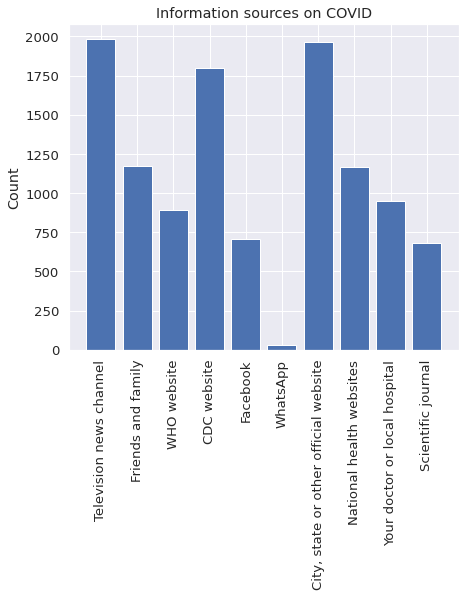

In [ ]:
# Bar char to visualize people's information sources on COVID
plt.figure(figsize=(7,6))
plt.bar(x=info_count.index, height=info_count['yes'])
plt.xticks(rotation='vertical')
plt.ylabel('Count')
plt.title('Information sources on COVID')
plt.show()

## 4.2 Bivariate Analysis

In [ ]:
def bi_visuals(column, title, xlabel, ylabel):
  # Creating a contigency table
  crosstab = rp.crosstab(covid_eda[column], covid_eda['covid_vaccine'], prop = 'row')
  # Plotting a stacked bar chart
  crosstab['covid_vaccine'][['no','yes']].drop('All').plot(kind = 'bar', stacked = True, figsize = (8,6))
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.xlabel(xlabel, labelpad=14)
  plt.ylabel(ylabel, labelpad=14)
  plt.title(title, y=1.02)
  return plt.show()

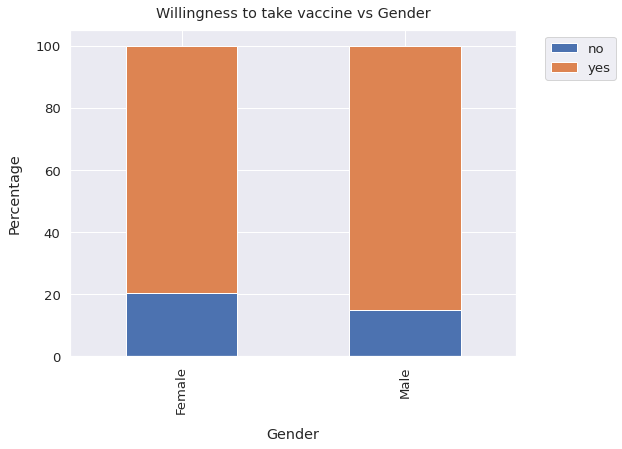

In [ ]:
# Willingness to take the vaccine vs gender
bi_visuals('Gender_string', 'Willingness to take vaccine vs Gender', 'Gender', 'Percentage')

A larger proportion of females are not willing to take the vaccine compared to their male counterparts

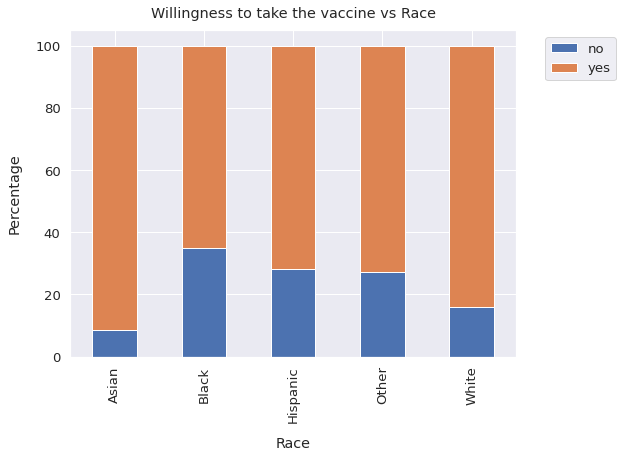

In [ ]:
# Willingness to take the vaccine vs race
bi_visuals('your_race', 'Willingness to take the vaccine vs Race', 'Race', 'Percentage')

A larger percentage of black people are unlikely to take the vaccine compared to people of other races.

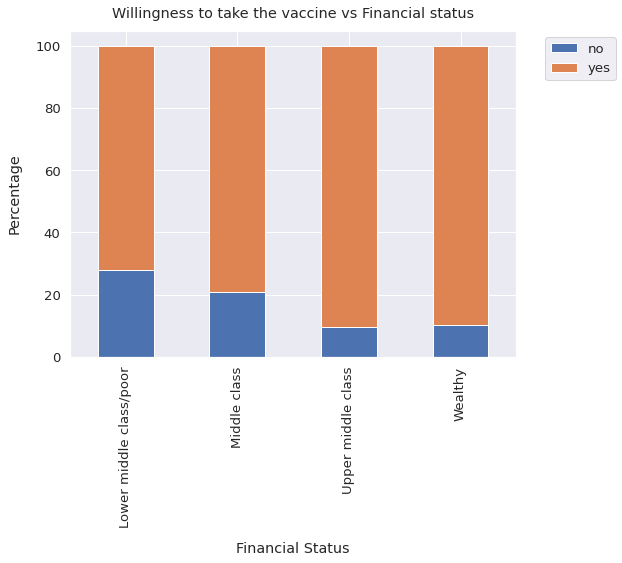

In [ ]:
# Willingness to take the vaccine vs financial status
bi_visuals('financial_status', 'Willingness to take the vaccine vs Financial status', 'Financial Status', 'Percentage')

A bigger percentage of lower middle class/poor people are unwilling to take the vaccine compared to middle class, upper middle class, wealthy people

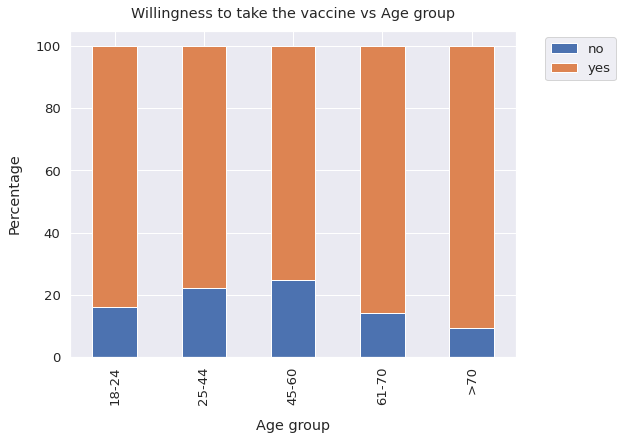

In [ ]:
# Willingness to take the vaccine vs age group
bi_visuals('your_age', 'Willingness to take the vaccine vs Age group', 'Age group', 'Percentage')

A bigger proportion of people aged between 45-60 are unlikely to take the vaccine compared to people of other ages

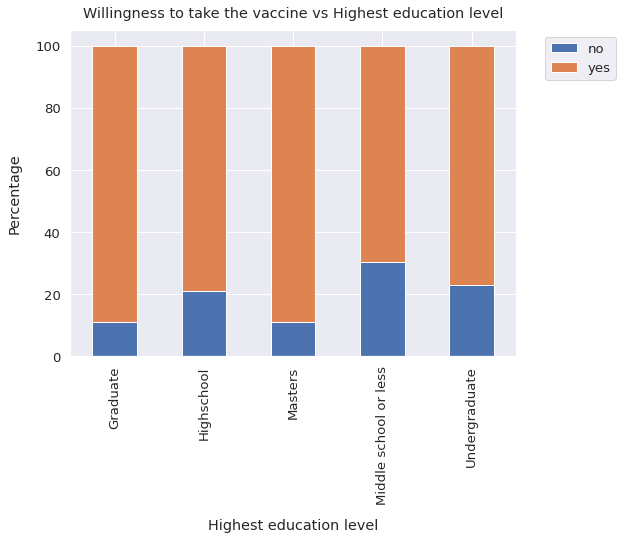

In [ ]:
# Willingness to take the vaccine vs Highest education level
bi_visuals('your_education', 'Willingness to take the vaccine vs Highest education level', 'Highest education level', 'Percentage')

A larger percentage of people who's highest level of education is middle school or less are not willing to take the vaccine

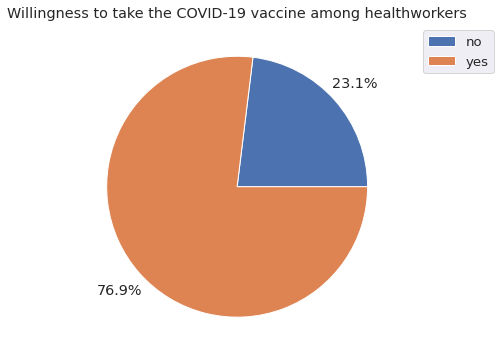

In [ ]:
# How is COVID-19 vaccine acceptance among health workers?
# Changing values from numerical to categorical
categorize(covid_eda, 'healthcare_worker', [0.0, 1.0], ['Non health care worker', 'Health care worker'])

# Creating a contigency table showing frequencies 
df = pd.crosstab(covid_eda['covid_vaccine'], covid_eda['healthcare_worker'])

# Pie chart showing percentages of healthcare workers willing and non willing to take a vaccine
plt.figure(figsize=(7,6))
plt.pie(x=df['Health care worker'], autopct='%1.1f%%', pctdistance=1.2)
plt.legend(df.index, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Willingness to take the COVID-19 vaccine among healthworkers')
plt.show()

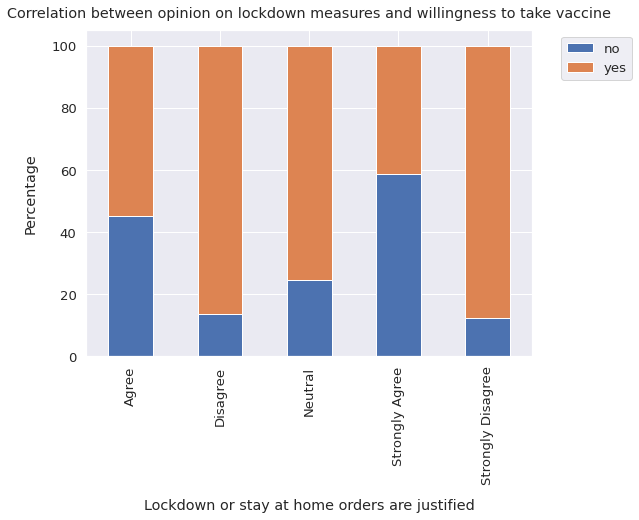

In [ ]:
# Changing values from numerical to categorical
categorize(covid_eda, 'ld', [1,2,3,4,5], ['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'])

# Willingness to take vaccine vs opinion on lockdown measures 
bi_visuals('ld', 'Correlation between opinion on lockdown measures and willingness to take vaccine', 'Lockdown or stay at home orders are justified', 'Percentage')

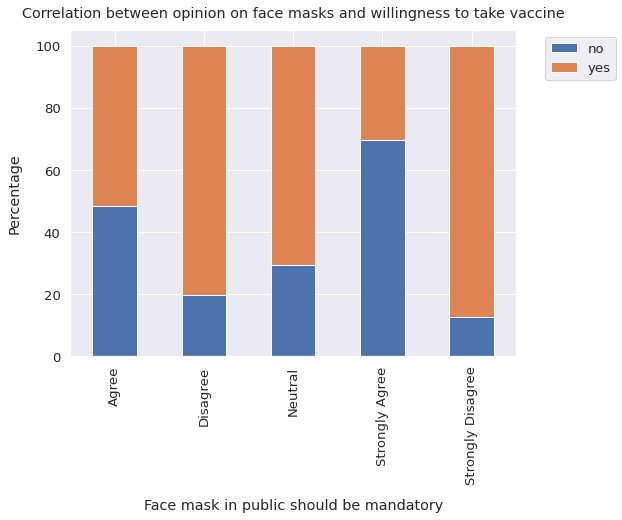

In [ ]:
# Changing values from numerical to categorical
categorize(covid_eda, 'fm', [1,2,3,4,5], ['Strongly Agree', 'Agree', 'Neutral', 'Disagree', 'Strongly Disagree'])

# Willingness to take vaccine vs opinion on face masks in pubic
bi_visuals('fm', 'Correlation between opinion on face masks and willingness to take vaccine', 'Face mask in public should be mandatory', 'Percentage')

## 4.3 Multivariate Analysis

We will conduct factor analysis to reduce the number of variables

In [ ]:
# Selecting the variables that we will conduct factor analysis on
# These variables are chosen because they are ordinal 
covid_multi = covid[['confine', 'job', 'infection', 'food', 'death', 'hospital_access', 'covid_state', 'sd', 'ld', 'hw', 'fm', 'er', 'reopening', 
                     'second_wave', 'number', 'state', 'belief', 'chloroquin', 'drug_trial', 'vaccine_trial', 'hospital', 'vent', 'administration', 
                     'social_distance_feet', 'isolation', 'corona_live', 'new_vaccine', 'new_medication']]
covid_multi.head()

,confine,job,infection,food,death,hospital_access,covid_state,sd,ld,hw,fm,er,reopening,second_wave,number,state,belief,chloroquin,drug_trial,vaccine_trial,hospital,vent,administration,social_distance_feet,isolation,corona_live,new_vaccine,new_medication
0,3.0,3.0,3.0,3.0,4.0,2.0,3.0,5.0,5.0,5.0,5.0,4.0,4.0,1.0,1.0,4.0,5.0,1.0,3.0,2.0,5.0,5.0,5.0,1.0,1.0,0.0,3.0,4.0
1,3.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,2.0,3.0,4.0,1.0,3.0,3.0,4.0,3.0,2.0,1.0,1.0,1.0,3.0,2.0
2,5.0,1.0,4.0,1.0,4.0,1.0,4.0,5.0,4.0,5.0,4.0,4.0,1.0,4.0,1.0,2.0,3.0,0.5,2.0,2.0,5.0,5.0,1.0,1.0,1.0,1.0,3.0,4.0
3,4.0,4.0,4.0,4.0,NaN,NaN,NaN,4.0,1.0,5.0,1.0,4.0,1.0,3.0,1.0,2.0,3.0,0.0,5.0,5.0,5.0,5.0,4.0,1.0,1.0,1.0,3.0,1.0
4,2.0,2.0,3.0,2.0,4.0,2.0,3.0,5.0,5.0,5.0,3.0,3.0,2.0,4.0,2.0,5.0,1.0,0.0,2.0,2.0,5.0,5.0,5.0,1.0,1.0,0.0,2.0,2.0


In [ ]:
# Checking our number of variables to reduce
covid_multi.shape[1]

28

In [ ]:
# Dropping null values
covid_multi.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Confirming that our variable types are numerical
covid_multi.dtypes

confine                 float64
job                     float64
infection               float64
food                    float64
death                   float64
hospital_access         float64
covid_state             float64
sd                      float64
ld                      float64
hw                      float64
fm                      float64
er                      float64
reopening               float64
second_wave             float64
number                  float64
state                   float64
belief                  float64
chloroquin              float64
drug_trial              float64
vaccine_trial           float64
hospital                float64
vent                    float64
administration          float64
social_distance_feet    float64
isolation               float64
corona_live             float64
new_vaccine             float64
new_medication          float64
dtype: object

Before we conduct factor analysis, we need to check that our dataset is factorable. 

To do this we will conduct Bartlett’s test of sphericity which compares an observed correlation matrix with the identity matrix

Null: Variables are not correlated i.e. not factorable

Alt: Variables are correlated enough i.e factorable

In [ ]:
# Importing Bartlett's test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Conducting the test
chi_square_value,p_value=calculate_bartlett_sphericity(covid_multi)
p_value

0.0

Our p value is less than 0.05 therefore we reject the null hypothesis and conclude that our variables are factorable

The second test is the Kaiser-Meyer-Olkin (KMO) Test which measures the suitability of data for factor analysis.

A KMO value of less than 0.6 is considered inadequate.

In [ ]:
# Importing the KMO test
from factor_analyzer.factor_analyzer import calculate_kmo

# Conducting the test
kmo_all,kmo_model=calculate_kmo(covid_multi)

# Finding out our results
kmo_model

0.848564668646457

The overall KMO for our dataset is 0.84 which is adequate

To determine the number of factors we will use the kaiser rule which is to drop all components with eigenvalues under 1.0. 

In [ ]:
# Importing factor analysis
from factor_analyzer.factor_analyzer import FactorAnalyzer

# Performing factor analysis
fa = FactorAnalyzer()
fa.analyze(covid_multi, 28, rotation=None)

# Checking the Eigenvalues
ev, v = fa.get_eigenvalues()
ev

,Original_Eigenvalues
0,5.687253
1,2.973302
2,1.946540
3,1.612209
4,1.267975
5,1.200932
6,1.063884
7,0.989237
8,0.970365
9,0.875606


As shown above 7 factors have an eigen value greater than one so we will chose 7 factors only

We can visualize the eigen-values with a scree plot

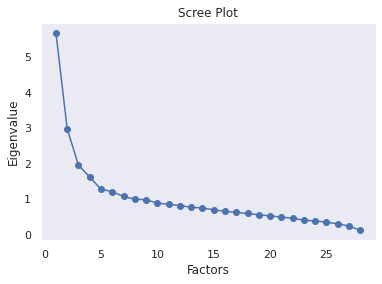

In [ ]:
# Creating the scree plot
plt.scatter(range(1,covid_multi.shape[1]+1),ev)
plt.plot(range(1,covid_multi.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [ ]:
# Performing factor analysis
fa = FactorAnalyzer()
fa.analyze(covid_multi, 7, rotation="varimax")
# Showing our factor loadings
# Factor loadings indicate how much a factor explains a variable
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
confine,-0.055706,0.483283,-0.048025,0.029416,0.050245,0.039216,-0.024219
job,-0.100050,0.582372,-0.017315,-0.089110,0.135418,0.048211,0.062671
infection,0.468014,0.596182,0.046167,-0.020531,-0.042195,-0.086470,-0.015094
food,-0.020387,0.676798,0.035291,-0.105636,0.114560,-0.083158,0.018991
death,0.306989,0.573923,0.036607,-0.041552,-0.049908,-0.002051,0.023406
hospital_access,0.020940,0.550580,0.055505,-0.328285,0.005770,-0.093540,0.006562
covid_state,0.399194,0.524177,0.035045,-0.109752,-0.084861,-0.129064,-0.218852
sd,0.745476,-0.011845,-0.073196,0.035661,-0.080255,-0.047401,0.284979
ld,0.841539,0.056144,-0.037469,-0.092683,0.052731,-0.120119,0.066021
hw,0.403664,0.138562,-0.016190,0.087879,0.032428,-0.016164,0.240129


In [ ]:
# Factor 1 - sd, ld, fm, reopening, second_wave, number, chloroquin, belief, state, hw, corona_live []
# Factor 2 - confine, job, infection, food, death, hospital_access, covid_state [Stress Related to COVID-19 Pandemic]
# Factor 3 - drug_trial, vaccine_trial [Willingness to participate in trials] 
# Factor 4 - hospital, vent, administration [Thoughts about your local hospital]
# Factor 5 - new_vaccine, new_medication [Future Hope]
# Factor 6 - er, isolation, social_distance_feet [Knowledge of COVID]
# Factor 7 -

In [ ]:
# Factor 7 has no high factor loadings for any variable so we performed factor analysis for 6 factors
fa = FactorAnalyzer()
fa.analyze(covid_multi, 6, rotation="varimax")
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
confine,-0.043861,0.481488,-0.049349,0.024376,0.028158,0.021868
job,-0.098806,0.564648,-0.015459,-0.079702,0.123700,-0.004929
infection,0.457468,0.609050,0.051337,-0.030109,-0.039368,-0.029821
food,-0.007880,0.676833,0.039900,-0.098488,0.129721,-0.093048
death,0.286959,0.584413,0.034610,-0.040625,-0.052612,0.014401
hospital_access,0.034991,0.548070,0.046367,-0.317888,0.032958,-0.141422
covid_state,0.394734,0.525278,0.030957,-0.158263,-0.076307,-0.013768
sd,0.726924,-0.009275,-0.055378,0.062024,-0.060664,-0.035908
ld,0.848510,0.060768,-0.018796,-0.100477,0.057721,-0.034647
hw,0.395677,0.125173,-0.000266,0.111025,0.031476,-0.034680


Factor 1 - Opinions on COVID-19
1. sd - Social distancing helps
2. ld - 'Lockdown' or 'stay at home' orders are justified
3. hw - 'Handwash for 20 seconds' whenever needed, is useful
4. fm - 'Face mask' in public should be mandatory
5. reopening - Reopening of your state is a right decision
6. second_wave - Reopening would lead to a second spike of COVID-19 cases
7. number - Actual number of COVID-19 cases are much higher than the number of reported cases
8. state - The situation of COVID-19 in your state is/was concerning
9. belief - COVID-19 can be controlled by the end of 2020
10. corona_live - Coronavirus can live on a surface for
11. chloroquin - Hydroxychloroquine (Plaquenil) is useful to treat COVID-19

Factor 2 - Stress Related to COVID-19 Pandemic
1. confine - Being confined at home with  minimal social interaction is
2. job - Job situation or possibility of financial instability is
3. infection - The possibility of getting infected with COVID-19 is
4. food - Possible shortage of food and other essentials in the coming months
5. death -One of your family members is at risk of serious complication due to COVID-19
6. hospital_access - Lack of access to a good medical facility
7. covid_state - Situation of COVID-19 at your state

Factor 3 - Willingness to participate in trials
1. drug_trial - I am willing to participate in future drug trials for COVID-19
2. vaccine - I am willing to participate in future vaccine trials for COVID-19

Factor 4 - Thoughts about your local hospital
1. hospital - Your local hospital can treat very sick COVID-19 patients
2. vent - Your local hospital has enough ventilators
3. administration - The government of your state/country acted promptly to prevent COVID-19

Factor 5 - Future Hope
1. new_vaccine - How soon do you think that a vaccine against COVID-19 will be available?
2. new_medication - How soon do you think that  a medication to cure COVID-19 will be available?

Factor 6 - Knowledge of COVID
1. social_distance_feet - Social distancing means keeping ____feet gap between two persons
2. isolation - If you had contact with a COVID-19 patient, you should be isolated for
3. er - One should go to Emergency/doctor immediately if he/she has symptoms like COVID-19


In [ ]:
# Getting variance of each factors
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
SS Loadings,4.530139,2.427528,1.838330,1.444760,0.766637,0.499214
Proportion Var,0.161791,0.086697,0.065655,0.051599,0.027380,0.017829
Cumulative Var,0.161791,0.248488,0.314143,0.365741,0.393121,0.410950


A total 41% cumulative variance is explained by our 6 factors

# 5. Hypothesis testing

Since we are comparing categorical variables we will conduct chi-square tests of independence

Null: There is no relationship between X and Y

Alt: There is a relationship between X and Y

In [ ]:
# Creating a user defined function to conduct our tests
def chi_test(column):
  crosstab = pd.crosstab(covid_eda[column], covid_eda['covid_vaccine'])
  p = stats.chi2_contingency(crosstab)[1]
  if p < 0.05:
    return print('Reject null hypothesis therefore there is a relationship')
  else:
    return print('Do not reject null hypothesis therefore there is no relationship')

In [ ]:
# Is there a relationship between willingness to take the COVID-19 vaccine and gender?
# Null: there is no relationship between willingness to take the COVID-19 vaccine and gender
# Alt: there is a relationship between willingness to take the COVID-19 vaccine and gender
chi_test('Gender_string')

Reject null hypothesis therefore there is a relationship


In [ ]:
# Is there a relationship between willingness to take the COVID-19 vaccine and race?
# Null: there is no relationship between willingness to take the COVID-19 vaccine and race
# Alt: there is a relationship between willingness to take the COVID-19 vaccine and race
chi_test('your_race')

Reject null hypothesis therefore there is a relationship


In [ ]:
# Is there a relationship between willingness to take the COVID-19 vaccine and financial status?
# Null: there is no relationship between willingness to take the COVID-19 vaccine and financial status
# Alt: there is a relationship between willingness to take the COVID-19 vaccine and financial status
chi_test('financial_status')

Reject null hypothesis therefore there is a relationship


In [ ]:
# Is there a relationship between willingness to take the COVID-19 vaccine and age group?
# Null: there is no relationship between willingness to take the COVID-19 vaccine and age group
# Alt: there is a relationship between willingness to take the COVID-19 vaccine and age group
chi_test('your_age')

Reject null hypothesis therefore there is a relationship


In [ ]:
# Is there a relationship between willingness to take the COVID-19 vaccine and level of education?
# Null: there is no relationship between willingness to take the COVID-19 vaccine and level of education
# Alt: there is a relationship between willingness to take the COVID-19 vaccine and level of education
chi_test('your_education')

Reject null hypothesis therefore there is a relationship
